Viser den rå data før ændingerne sker, den vises kun for at få et før/efter billede af dataen.

In [32]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
"""Shows data before it is changed"""
data = pd.read_csv("Sleep_health_and_lifestyle_dataset_no_duplicates.csv")
print(data.to_string())

     Gender   Age   Occupation             Sleep Duration   Quality of Sleep   Physical Activity Level   Stress Level   BMI Category    Blood Pressure   Heart Rate   Daily Steps  Sleep Disorder
0    Male       27  Software Engineer                  6.1                  6                        42              6  Overweight      126/83                    77          4200            NaN
1    Male       28  Doctor                             6.2                  6                        60              8  Normal          125/80                    75         10000            NaN
2    Male       28  Sales Representative               5.9                  4                        30              8  Obese           140/90                    85          3000    Sleep Apnea
3    Male       28  Software Engineer                  5.9                  4                        30              8  Obese           140/90                    85          3000       Insomnia
4    Male       29  Teacher   

Fjerne ekstra mellemrum som skader databehandlingen for strings

In [33]:
# Fjern mellemrum i kolonnenavne
data.columns = data.columns.str.strip()

# Fjern ekstra mellemrum i værdierne i 'BMI Category'
data['BMI Category'] = data['BMI Category'].str.strip()

Ordinal encoding laves, for BMI, der bliver også samlet på Normal og Normal Weight

In [34]:
"""BMI category ordinal encoding"""
weight_mapping = {
    'Underweight': 0,
    'Normal': 1,
    'Normal Weight': 1,
    'Overweight': 2,
    'Obese': 3
}
# Apply the mapping
data['Weight_Category_BMI'] = data['BMI Category'].map(weight_mapping)

Køn bliver ændret. Kvinde = 0 og Mand = 1

In [35]:
# Map genders to numerical values
gender_mapping = {
    'Female': 0,
    'Male': 1
}

# Apply the mapping to the 'Gender' column
data['Gender_Numerical'] = data['Gender'].str.strip().map(gender_mapping)


De næste 4 omgange kode laver scaling så alle værdier ender i intervallet mellem 1 og 10 i stedet for deres respektive. https://www.geeksforgeeks.org/normalization-and-scaling/

In [36]:
# Scale the 'Physical Activity Level' column
data['Physical Activity Level (scaled)'] = 1 + (data['Physical Activity Level'] - 1) * (10 - 1) / (100 - 1)

In [37]:
# Scale the 'Heart Rate' column
data['Heart Rate (scaled)'] = 1 + (data['Heart Rate'] - 1) * (10 - 1) / (100 - 1)

In [38]:
# Scale the 'Daily Steps' column
data['Daily Steps (scaled)'] = 1 + (data['Daily Steps'] - 1) * (10 - 1) / (10000 - 1)

In [39]:
# Scale the 'Age' column
data['Age (scaled)'] = 1 + (data['Age'] - 1) * (10 - 1) / (100 - 1)

Laver stress om til binær (Skal genbesøges, da vi skal teste flere stress kategorier)

In [40]:
"""Binary stress 0 = not stressed 1 = stressed"""
# Define a binary encoding for 'Stress Level': 0 for not stressed (1-5), 1 for stressed (6-10)
data['Stress_Binary'] = data['Stress Level'].apply(lambda x: 1 if 6 <= x <= 10 else 0)

Fjerner irrelevante kolonner

In [41]:
"""Remove columns which are not important"""
# Remove the 'User_ID and age' column
data = data.drop(columns=["Occupation", "Sleep Disorder", "Blood Pressure", "BMI Category", "Physical Activity Level", "Daily Steps", "Stress Level", "Gender", "Heart Rate", "Age"])

Hvis man vil se alle data, så fjern #, samt data.head og data.tail i næste kodestykke

In [42]:
"""Fjern # hvis du vil se hele datasættet"""
#pd.set_option('display.max_rows', None)  # Show all rows
#pd.set_option('display.max_columns', None)  # Show all columns

#from IPython.display import display
#display(data)

data.head(5)

,Sleep Duration,Quality of Sleep,Weight_Category_BMI,Gender_Numerical,Physical Activity Level (scaled),Heart Rate (scaled),Daily Steps (scaled),Age (scaled),Stress_Binary
0,6.1,6,2,1,4.727273,7.909091,4.779478,3.363636,1
1,6.2,6,1,1,6.363636,7.727273,10.000000,3.454545,1
2,5.9,4,3,1,3.636364,8.636364,3.699370,3.454545,1
3,5.9,4,3,1,3.636364,8.636364,3.699370,3.454545,1
4,6.3,6,3,1,4.545455,8.363636,4.149415,3.545455,1


In [43]:
data.tail(5)

,Sleep Duration,Quality of Sleep,Weight_Category_BMI,Gender_Numerical,Physical Activity Level (scaled),Heart Rate (scaled),Daily Steps (scaled),Age (scaled),Stress_Binary
127,8.0,9,2,0,7.727273,7.090909,7.29973,6.272727,0
128,8.1,9,2,0,7.727273,7.090909,7.29973,6.272727,0
129,8.2,9,2,0,7.727273,7.090909,7.29973,6.272727,0
130,8.0,9,2,0,7.727273,7.090909,7.29973,6.272727,0
131,8.1,9,2,0,7.727273,7.090909,7.29973,6.272727,0


In [44]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare features (X) and target (y)
X = data.drop(columns=['Stress_Binary'])  # Features
y = data['Stress_Binary']  # Target

# Define the SVM model
svm_model = SVC(kernel='linear', random_state=42)

# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0)
}

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calculate and print cross-validation results for each metric
print("Cross-Validation Results:")
for metric_name, scorer in scoring.items():
    scores = cross_val_score(svm_model, X, y, cv=cv, scoring=scorer)
    print(f"{metric_name.capitalize()}: {scores.mean():.4f} ± {scores.std():.4f}")


Cross-Validation Results:
Accuracy: 0.9476 ± 0.0501
Precision: 0.9562 ± 0.0373
Recall: 0.9476 ± 0.0501


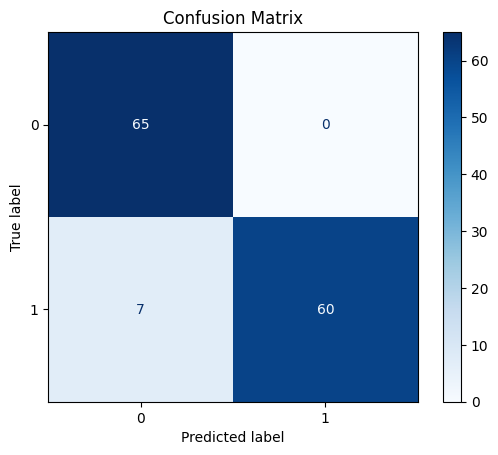

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Initialize StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Arrays to store true and predicted labels across all folds
true_labels = []
predicted_labels = []

# Perform cross-validation and collect predictions
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    svm_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = svm_model.predict(X_test)

    # Collect results
    true_labels.extend(y_test)
    predicted_labels.extend(y_pred)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


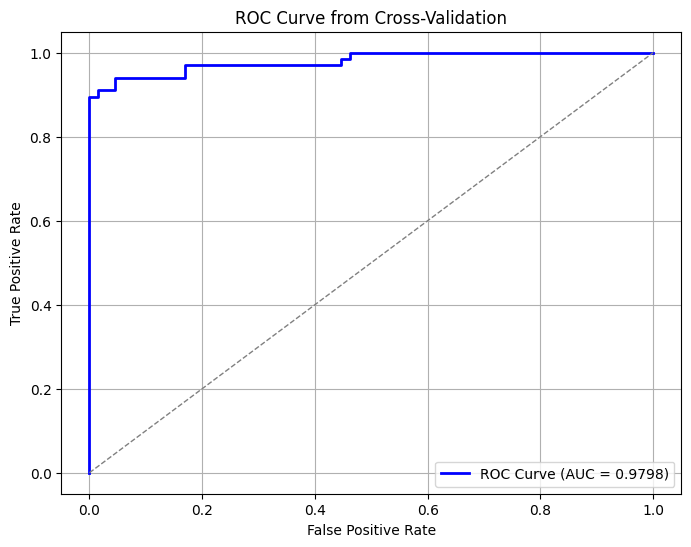

In [46]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Initialize lists to store true labels and predicted probabilities
true_labels = []
predicted_probs = []

# Perform cross-validation and collect predictions
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    svm_model.fit(X_train, y_train)

    # Predict probabilities for the positive class
    y_prob = svm_model.decision_function(X_test)  # Use `decision_function` for SVM
    true_labels.extend(y_test)
    predicted_probs.extend(y_prob)

# Compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs, pos_label=1)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve from Cross-Validation")
plt.legend(loc="lower right")
plt.grid()
plt.show()
